# Neural Networks - Part 3

### Contents

* MNIST
* Sequential API
* Saving and restoring models
* Using callbacks
* Exercises

In the previous exercise we set up a Multilayer Perceptron to model the Iris Dataset. Here we consider the [MNIST handwritten digits database](https://en.wikipedia.org/wiki/MNIST_database) to investigate further aspects of setting up Neural Networks. This is a collection of 60,000 training images and 10,000 testing images, which have been digitised onto a 28x28 grid.

First we import Tensorflow and Keras.

In [21]:


import tensorflow as tf
from tensorflow import keras


C:\Users\Simon\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We import from `keras` a built-in function to load the MNIST data set. From `keras` we introduce the functions `Sequential`, which creates a feed-forward neural network and `Dense` which creates a fully connected network for each layer. We also introduce `SGD` which implements stochastic gradient descent.

Finally, we introduce the usual suspects.

In [22]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## MNIST

We first load the MNIST data. This comes already split into a training and testing set. The features are black and white images which are pixellated onto a 28x28 grid, with intensities ranging from 0 to 255. The targets values are the digit (0-9) that each image corresponds to.

In [23]:
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [24]:
X_train_full.shape

(60000, 28, 28)

In [25]:
y_train_full.shape

(60000,)

We can plot the first 40 images in the training set, along with their target values.

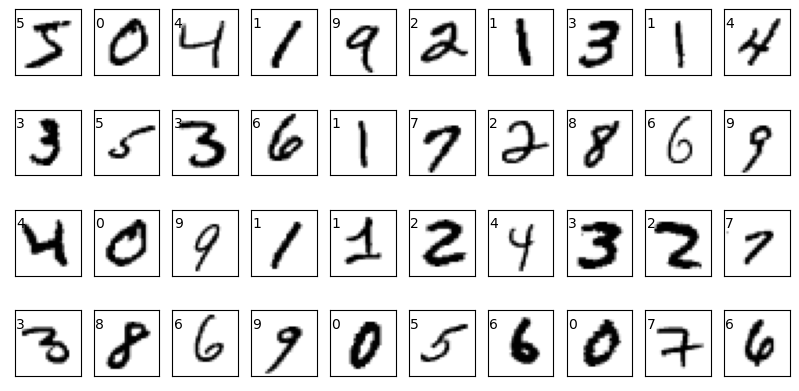

In [26]:
fig = plt.figure(figsize=(10,5)) # set up a figure of size 10 x 5

for i in range(40): # loop over the first 40 images
    # on a 4 x 10 grid add the next plot with no xticks or yticks
    ax = fig.add_subplot(4,10,i+1,xticks=[],yticks=[])
    # plot the image i of the digits and use binary colourmap
    ax.imshow(X_train_full[i], cmap=plt.cm.binary)
    ax.text(0,7,str(y_train_full[i])) # add the target value in the lower left corner

This is now split into a training set and a validation set, and the features are normalized so that the pixel values ranges from 0 to 1.

In [27]:
X_valid = X_train_full[:5000]/255.0
X_train = X_train_full[5000:]/255.0
y_valid = y_train_full[:5000]
y_train = y_train_full[5000:]

## Sequential API

Previously we used a single call to initialize the Neural Network, however a cleaner way to do this is to initialize the model and then use the `model.add()` method to sequentially add layers. We need to specify the input shape is a 28x28 matrix, _flatten_ that to convert it to a vector and that the output corresponds to 10 possible categories. The number of hidden layers and the number of neurons in each hidden layer is then arbitrary. For each of the nodes in the hidden layers the ReLU activation function is used.

We store the weights and biases of the model using `model.get_weights()`, so that we can reset the model for later runs.

There is also a Functional API to create models, which allows the creation of more complex Neural Networks.

In [28]:
model = Sequential()
model.add(Flatten(input_shape=[28, 28]))
model.add(Dense(300, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

weights = model.get_weights();

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To compile the model we use the loss function `sparse_categorical_crossentropy`, as we have mutually exclusive target values for the variables ranging from 0-9. For the Iris data set we used one-hot encoding which created a binary table with each column corresponding to whether or not that instance corresponds to a particular species. In that case with one-hot encoding the appropriate loss function is `categorical_crossentropy`.

We will use SGD with the default learning rate of `lr=0.01` and decay rate of `decay=0`.

In [29]:
opt = SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

Finally we can train the model. In this example we use only 50 epochs (iterations) and use explicit validation datasets. Previously, we specified what proportion of the training set should be used for validation. Due to the large size of the input data (784 features compared with 4 features for the Iris data), training takes significantly longer. For each epoch only 32 randomly chosen instances (the default batch size) are chosen for training the model.

In [30]:
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid), verbose=2);

Epoch 1/50
1719/1719 - 4s - loss: 0.6372 - accuracy: 0.8356 - val_loss: 0.3186 - val_accuracy: 0.9148 - 4s/epoch - 2ms/step
Epoch 2/50
1719/1719 - 3s - loss: 0.2968 - accuracy: 0.9152 - val_loss: 0.2534 - val_accuracy: 0.9276 - 3s/epoch - 2ms/step
Epoch 3/50
1719/1719 - 3s - loss: 0.2440 - accuracy: 0.9302 - val_loss: 0.2162 - val_accuracy: 0.9416 - 3s/epoch - 2ms/step
Epoch 4/50
1719/1719 - 3s - loss: 0.2094 - accuracy: 0.9403 - val_loss: 0.1870 - val_accuracy: 0.9484 - 3s/epoch - 2ms/step
Epoch 5/50
1719/1719 - 3s - loss: 0.1833 - accuracy: 0.9481 - val_loss: 0.1642 - val_accuracy: 0.9558 - 3s/epoch - 2ms/step
Epoch 6/50
1719/1719 - 3s - loss: 0.1623 - accuracy: 0.9535 - val_loss: 0.1509 - val_accuracy: 0.9606 - 3s/epoch - 2ms/step
Epoch 7/50
1719/1719 - 4s - loss: 0.1460 - accuracy: 0.9589 - val_loss: 0.1362 - val_accuracy: 0.9652 - 4s/epoch - 2ms/step
Epoch 8/50
1719/1719 - 4s - loss: 0.1324 - accuracy: 0.9624 - val_loss: 0.1271 - val_accuracy: 0.9668 - 4s/epoch - 2ms/step
Epoch 9/

The loss and accuracy of the training and validation sets are stored in history and can now be plotted as a function of the epochs of the model. The behaviour looks reasonable where there is no significant difference between the testing and validation data, and the accuracy is generally monotonically increasing, while the loss is monotonically decreasing. However, the validation loss and accuracy appear to not have any significant changes after approximately 20 epochs.

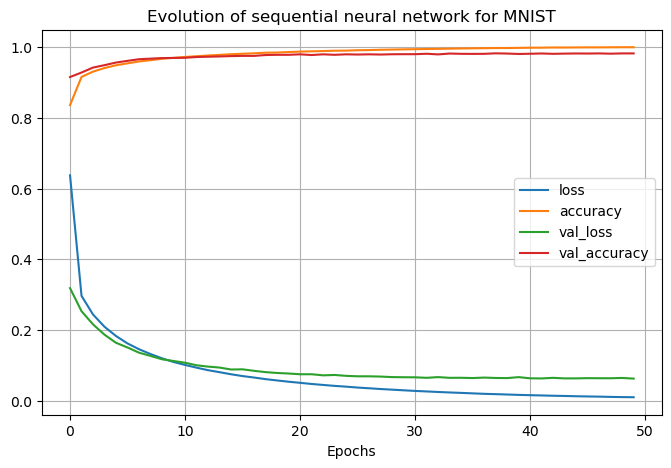

In [31]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('Epochs')
plt.title('Evolution of sequential neural network for MNIST');

Finally we can use the testing set to determine the accuracy of the model. This can be done using the `evaluate` function for the model. As can be seen the accuracy for the test set is consistent with the accuracy of the validation set.

In [33]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 14.5885 - accuracy: 0.9765


[14.588479995727539, 0.9764999747276306]

We can also investigate other measures of the accuracy using the actual classifications of the model. The model predicts the probability of a particular classification. To find the actual classification we then just need to find the column in each row with the maximum probability using the function `argmax()`. The precision gives an indication of what percentage of the predictions of that digit are correct, while the recall gives an indication of what percentage of the actual samples for that digit are predicted correctly. The F1-score gives a weighted average of the precision and recall. For a perfect model all of these would be 1.

The support is the number of actual samples for that digit.

As can be seen, for this model the recall for 3 is the lowest and the precision for 8 is the lowest.

In [34]:
proba = model.predict(X_test)
y_test.shape

313/313 [==============================] - 0s 1ms/step


(10000,)

In [35]:
print(classification_report(proba.argmax(axis=1), y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       989
           1       0.99      0.98      0.99      1149
           2       0.97      0.97      0.97      1033
           3       0.99      0.95      0.97      1052
           4       0.98      0.98      0.98       980
           5       0.97      0.98      0.98       881
           6       0.98      0.98      0.98       957
           7       0.98      0.97      0.98      1031
           8       0.94      0.99      0.97       927
           9       0.96      0.97      0.97      1001

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



The overall accuracy can also be investigated by plotting the confusion matrix for the classifications. Here we see the same conclusions as from the classification report. The main problem appears to be 3 being predicted as 5 or 8.

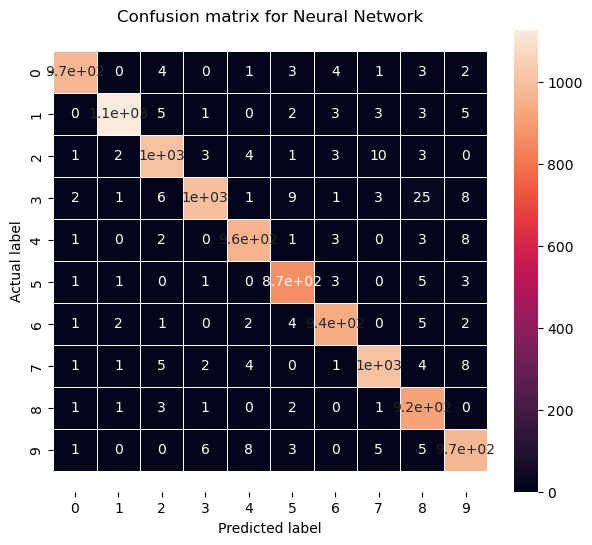

In [36]:
def plt_confusion_matrix(cnf_matrix, cats, method):
    """
    Plots a sklearn confusion matrix with categories 'cats' for a classifier 'method'
    """
    # write the confusion matrix to a dataframe with row and column names as the categories,
    # which are already defined
    cmatrix = pd.DataFrame(cnf_matrix,columns=cats,index=cats)
    f, ax = plt.subplots(figsize=(7,6)) # initialise the plots and axes
    sns.heatmap(cmatrix, annot=True, linewidths=.5) # plot the confusion matrix as a heatmap
    plt.title('Confusion matrix for '+method) # add a title, + concatenates two strings
    plt.ylabel('Actual label') # add a ylabel
    plt.xlabel('Predicted label') # add a xlabel
    # adjust the bottom and top of the figure, so we can view all of it
    bottom, top = ax.get_ylim()  # get the y axis limits
    ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

# create a confusion matrix for our actual and predicted values
cnf_matrix = confusion_matrix(proba.argmax(axis=1), y_test)
plt_confusion_matrix(cnf_matrix, ['0','1','2','3','4','5','6','7','8','9'], 'Neural Network')

## Saving the model

Since the models take a while to run, we don't want to repeat the training every time we are using the model. We can therefore use `model.save()` to save all the parameters and hyperparameters for the model in HDF5 (a scientific data format).

In [37]:
model.save("KerasMnistModel.hd5")
!ls

INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets
'ls' is not recognized as an internal or external command,
operable program or batch file.


Then next time we can load the model using `load_model()`. As can be seen this gives the same accuracy on our testing set.

In [38]:
newmodel = keras.models.load_model("KerasMnistModel.hd5")
newmodel.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 14.5885 - accuracy: 0.9765


[14.588479995727539, 0.9764999747276306]

We can also store the model after each epoch. For example, this might be useful on Google Colab if you have a very long training run which exceeds 12 hours. Then the last state of the model is saved before the run ends and the model training can be restarted from this last state. Alternatively, your computer might crash during a training run, and then you can restart the calculation at the last state.

To store the model we use `ModelCheckpoint` to create a _callback_ for Keras which tells the program what to do at the beginning and end of each epoch. We also need to reinitialize the model, so that the weights are set randomly. Otherwise, the last values of the weights and biases would be used.

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint

model.set_weights(weights)
checkpoint_cb = ModelCheckpoint("KerasMnistModel.hd5")
history1 = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid), verbose=2,
                    callbacks=[checkpoint_cb]);

Epoch 1/10
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.6382 - accuracy: 0.8344 - val_loss: 0.3159 - val_accuracy: 0.9128 - 4s/epoch - 2ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.2953 - accuracy: 0.9151 - val_loss: 0.2454 - val_accuracy: 0.9320 - 3s/epoch - 2ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.2426 - accuracy: 0.9310 - val_loss: 0.2090 - val_accuracy: 0.9436 - 4s/epoch - 2ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.2080 - accuracy: 0.9403 - val_loss: 0.1855 - val_accuracy: 0.9488 - 4s/epoch - 2ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.1826 - accuracy: 0.9478 - val_loss: 0.1643 - val_accuracy: 0.9562 - 4s/epoch - 2ms/step
Epoch 6/10
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.1622 - accuracy: 0.9537 - val_loss: 0.1500 - val_accuracy: 0.9584 - 4s/epoch - 2ms/step
Epoch 7/10
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.1459 - accuracy: 0.9583 - val_loss: 0.1370 - val_accuracy: 0.9612 - 4s/epoch - 2ms/step
Epoch 8/10
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.1323 - accuracy: 0.9623 - val_loss: 0.1255 - val_accuracy: 0.9644 - 4s/epoch - 2ms/step
Epoch 9/10
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.1208 - accuracy: 0.9662 - val_loss: 0.1196 - val_accuracy: 0.9660 - 4s/epoch - 2ms/step
Epoch 10/10
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.1106 - accuracy: 0.9694 - val_loss: 0.1127 - val_accuracy: 0.9684 - 4s/epoch - 2ms/step


This can be refined by only saving models which have a better accuracy than any previous epochs by specifying `save_best_only=True`. Then the final model which is saved is the most accurate model from the training run. We also use the validation accurcay, rather than the validation loss. Now we see that for this simulation we run 20 epochs, but not all of the epochs are stored due to the accuracy not improving from previous epochs.

We can also also suppress the model output by specifying `verbose=0`.

In [40]:
model.set_weights(weights)
checkpoint_cb = ModelCheckpoint("KerasMnistModel.hd5", monitor='val_accuracy',
                                save_best_only=True, verbose=1)
history2 = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), verbose=0,
                    callbacks=[checkpoint_cb]);


Epoch 1: val_accuracy improved from -inf to 0.91280, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 2: val_accuracy improved from 0.91280 to 0.93220, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 3: val_accuracy improved from 0.93220 to 0.94000, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 4: val_accuracy improved from 0.94000 to 0.94860, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 5: val_accuracy improved from 0.94860 to 0.95600, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 6: val_accuracy improved from 0.95600 to 0.95780, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 7: val_accuracy improved from 0.95780 to 0.96300, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 8: val_accuracy improved from 0.96300 to 0.96560, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 9: val_accuracy did not improve from 0.96560

Epoch 10: val_accuracy improved from 0.96560 to 0.96800, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 11: val_accuracy improved from 0.96800 to 0.96920, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 12: val_accuracy improved from 0.96920 to 0.96960, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 13: val_accuracy improved from 0.96960 to 0.97160, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 14: val_accuracy improved from 0.97160 to 0.97340, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 15: val_accuracy improved from 0.97340 to 0.97520, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 16: val_accuracy did not improve from 0.97520

Epoch 17: val_accuracy improved from 0.97520 to 0.97580, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 18: val_accuracy did not improve from 0.97580

Epoch 19: val_accuracy improved from 0.97580 to 0.97700, saving model to KerasMnistModel.hd5
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets



Epoch 20: val_accuracy did not improve from 0.97700


Callbacks can also be used to stop the training once the model accuracy is not improving. To do this we use the `EarlyStopping` method and specify the parameter `patience`. Here we use `patience=2`, which states that if the model accuracy (which is measured again using the validation accuracy) does not improve over the last 2 epochs, then the training is stopped. Consequently, the training is stopped at epoch 33.

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

opt = SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
model.set_weights(weights)
checkpoint_cb = ModelCheckpoint("KerasMnistModel.hd5", monitor='val_accuracy',
                                save_best_only=True)
early_stopping_cb = EarlyStopping(patience=2,
                                  restore_best_weights=True)
history3 = model.fit(X_train, y_train, epochs=40,
                    validation_data=(X_valid, y_valid), verbose=2,
                    callbacks=[checkpoint_cb, early_stopping_cb]);

Epoch 1/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.6365 - accuracy: 0.8357 - val_loss: 0.3111 - val_accuracy: 0.9164 - 4s/epoch - 2ms/step
Epoch 2/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.2968 - accuracy: 0.9153 - val_loss: 0.2474 - val_accuracy: 0.9326 - 4s/epoch - 2ms/step
Epoch 3/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.2437 - accuracy: 0.9303 - val_loss: 0.2095 - val_accuracy: 0.9396 - 4s/epoch - 2ms/step
Epoch 4/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.2086 - accuracy: 0.9411 - val_loss: 0.1842 - val_accuracy: 0.9496 - 4s/epoch - 2ms/step
Epoch 5/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.1823 - accuracy: 0.9481 - val_loss: 0.1646 - val_accuracy: 0.9560 - 4s/epoch - 2ms/step
Epoch 6/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.1613 - accuracy: 0.9537 - val_loss: 0.1552 - val_accuracy: 0.9568 - 3s/epoch - 2ms/step
Epoch 7/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.1452 - accuracy: 0.9585 - val_loss: 0.1366 - val_accuracy: 0.9612 - 3s/epoch - 2ms/step
Epoch 8/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.1312 - accuracy: 0.9637 - val_loss: 0.1273 - val_accuracy: 0.9654 - 3s/epoch - 2ms/step
Epoch 9/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.1195 - accuracy: 0.9664 - val_loss: 0.1171 - val_accuracy: 0.9676 - 3s/epoch - 2ms/step
Epoch 10/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.1097 - accuracy: 0.9693 - val_loss: 0.1114 - val_accuracy: 0.9684 - 3s/epoch - 2ms/step
Epoch 11/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.1009 - accuracy: 0.9717 - val_loss: 0.1055 - val_accuracy: 0.9698 - 3s/epoch - 2ms/step
Epoch 12/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.0928 - accuracy: 0.9743 - val_loss: 0.1007 - val_accuracy: 0.9710 - 3s/epoch - 2ms/step
Epoch 13/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.0865 - accuracy: 0.9761 - val_loss: 0.0965 - val_accuracy: 0.9718 - 4s/epoch - 2ms/step
Epoch 14/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.0803 - accuracy: 0.9775 - val_loss: 0.0938 - val_accuracy: 0.9736 - 4s/epoch - 3ms/step
Epoch 15/40
1719/1719 - 4s - loss: 0.0748 - accuracy: 0.9793 - val_loss: 0.0917 - val_accuracy: 0.9736 - 4s/epoch - 2ms/step
Epoch 16/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 5s - loss: 0.0698 - accuracy: 0.9810 - val_loss: 0.0874 - val_accuracy: 0.9750 - 5s/epoch - 3ms/step
Epoch 17/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.0654 - accuracy: 0.9821 - val_loss: 0.0846 - val_accuracy: 0.9764 - 4s/epoch - 2ms/step
Epoch 18/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.0612 - accuracy: 0.9835 - val_loss: 0.0817 - val_accuracy: 0.9770 - 4s/epoch - 3ms/step
Epoch 19/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.0575 - accuracy: 0.9843 - val_loss: 0.0782 - val_accuracy: 0.9782 - 4s/epoch - 3ms/step
Epoch 20/40
1719/1719 - 4s - loss: 0.0543 - accuracy: 0.9853 - val_loss: 0.0782 - val_accuracy: 0.9770 - 4s/epoch - 2ms/step
Epoch 21/40
1719/1719 - 4s - loss: 0.0510 - accuracy: 0.9866 - val_loss: 0.0754 - val_accuracy: 0.9780 - 4s/epoch - 2ms/step
Epoch 22/40
1719/1719 - 4s - loss: 0.0479 - accuracy: 0.9875 - val_loss: 0.0745 - val_accuracy: 0.9778 - 4s/epoch - 2ms/step
Epoch 23/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.0449 - accuracy: 0.9883 - val_loss: 0.0734 - val_accuracy: 0.9786 - 4s/epoch - 2ms/step
Epoch 24/40
1719/1719 - 4s - loss: 0.0425 - accuracy: 0.9889 - val_loss: 0.0725 - val_accuracy: 0.9784 - 4s/epoch - 2ms/step
Epoch 25/40
1719/1719 - 4s - loss: 0.0399 - accuracy: 0.9900 - val_loss: 0.0717 - val_accuracy: 0.9782 - 4s/epoch - 2ms/step
Epoch 26/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.0377 - accuracy: 0.9905 - val_loss: 0.0694 - val_accuracy: 0.9794 - 4s/epoch - 2ms/step
Epoch 27/40
1719/1719 - 4s - loss: 0.0354 - accuracy: 0.9915 - val_loss: 0.0714 - val_accuracy: 0.9784 - 4s/epoch - 2ms/step
Epoch 28/40
1719/1719 - 4s - loss: 0.0336 - accuracy: 0.9918 - val_loss: 0.0682 - val_accuracy: 0.9792 - 4s/epoch - 2ms/step
Epoch 29/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 4s - loss: 0.0317 - accuracy: 0.9923 - val_loss: 0.0686 - val_accuracy: 0.9804 - 4s/epoch - 2ms/step
Epoch 30/40
1719/1719 - 4s - loss: 0.0299 - accuracy: 0.9931 - val_loss: 0.0675 - val_accuracy: 0.9794 - 4s/epoch - 2ms/step
Epoch 31/40
1719/1719 - 3s - loss: 0.0282 - accuracy: 0.9935 - val_loss: 0.0677 - val_accuracy: 0.9800 - 3s/epoch - 2ms/step
Epoch 32/40
1719/1719 - 3s - loss: 0.0267 - accuracy: 0.9938 - val_loss: 0.0668 - val_accuracy: 0.9800 - 3s/epoch - 2ms/step
Epoch 33/40
1719/1719 - 3s - loss: 0.0252 - accuracy: 0.9943 - val_loss: 0.0662 - val_accuracy: 0.9802 - 3s/epoch - 2ms/step
Epoch 34/40
1719/1719 - 3s - loss: 0.0239 - accuracy: 0.9951 - val_loss: 0.0676 - val_accuracy: 0.9800 - 3s/epoch - 2ms/step
Epoch 35/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.0226 - accuracy: 0.9952 - val_loss: 0.0657 - val_accuracy: 0.9810 - 3s/epoch - 2ms/step
Epoch 36/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.0213 - accuracy: 0.9958 - val_loss: 0.0643 - val_accuracy: 0.9814 - 3s/epoch - 2ms/step
Epoch 37/40
INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


INFO:tensorflow:Assets written to: KerasMnistModel.hd5\assets


1719/1719 - 3s - loss: 0.0201 - accuracy: 0.9961 - val_loss: 0.0647 - val_accuracy: 0.9820 - 3s/epoch - 2ms/step
Epoch 38/40
1719/1719 - 3s - loss: 0.0191 - accuracy: 0.9966 - val_loss: 0.0656 - val_accuracy: 0.9820 - 3s/epoch - 2ms/step


Finally, callbacks can be used to modify the learning rate. This can be done by creating user defined functions in conjunction with `LearningRateScheduler` or by using `ReduceLROnPlateau`. We will just consider the latter here. In this case if the accuracy has plateaued over the recent epochs as specified by `patience`, then the learning rate can be reduced by the rate `factor`. Here we specify `factor=0.5`, which causes the learning rate to be reduced by a factor of 2 when the accuracy has plateaued. The rationale is that with a smaller learning rate the training will converge to a minimum, whereas for larger value the training will oscillate around the minimum.

In [46]:
from keras.callbacks import ReduceLROnPlateau

opt = SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
model.set_weights(weights)
reducelr_cb = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)
history4 = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), verbose=2,
                    callbacks=[reducelr_cb]);


Epoch 1/30
1719/1719 - 4s - loss: 0.6375 - accuracy: 0.8345 - val_loss: 0.3150 - val_accuracy: 0.9158 - lr: 0.0100 - 4s/epoch - 2ms/step
Epoch 2/30
1719/1719 - 3s - loss: 0.2971 - accuracy: 0.9144 - val_loss: 0.2486 - val_accuracy: 0.9304 - lr: 0.0100 - 3s/epoch - 2ms/step
Epoch 3/30
1719/1719 - 3s - loss: 0.2439 - accuracy: 0.9310 - val_loss: 0.2088 - val_accuracy: 0.9410 - lr: 0.0100 - 3s/epoch - 2ms/step
Epoch 4/30
1719/1719 - 3s - loss: 0.2088 - accuracy: 0.9403 - val_loss: 0.1890 - val_accuracy: 0.9472 - lr: 0.0100 - 3s/epoch - 2ms/step
Epoch 5/30
1719/1719 - 3s - loss: 0.1826 - accuracy: 0.9489 - val_loss: 0.1641 - val_accuracy: 0.9558 - lr: 0.0100 - 3s/epoch - 2ms/step
Epoch 6/30
1719/1719 - 3s - loss: 0.1625 - accuracy: 0.9538 - val_loss: 0.1533 - val_accuracy: 0.9584 - lr: 0.0100 - 3s/epoch - 2ms/step
Epoch 7/30
1719/1719 - 3s - loss: 0.1458 - accuracy: 0.9586 - val_loss: 0.1389 - val_accuracy: 0.9626 - lr: 0.0100 - 3s/epoch - 2ms/step
Epoch 8/30
1719/1719 - 3s - loss: 0.1320 

Plotting the learning rate, we see that the learning rate is reduced at least thrice, with a gradual improvement in the validation accuracy.

<Figure size 800x700 with 0 Axes>

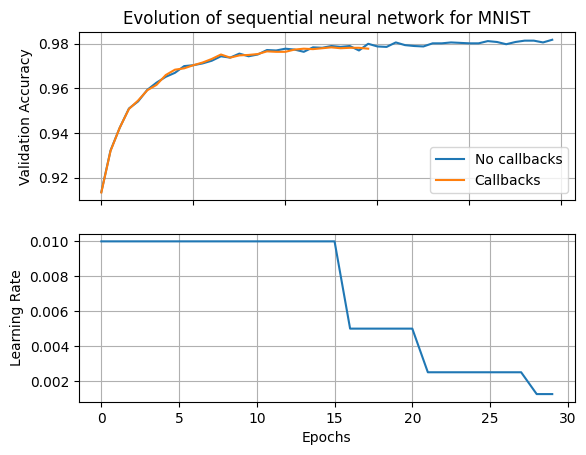

In [73]:
plt.figure(figsize=(8,7))

fig, axs = plt.subplots(2, 1)
axs[0].plot(history.history['val_accuracy'])
axs[0].plot(history4.history['val_accuracy'])
axs[0].set_ylabel('Validation Accuracy')
axs[0].xaxis.set_ticklabels([])

axs[0].legend(['No callbacks', 'Callbacks'], loc='lower right')
axs[0].grid(True)
axs[0].set_title('Evolution of sequential neural network for MNIST');

axs[1].plot(history4.history['lr'])
axs[1].set_ylabel('Learning Rate')
axs[1].set_xlabel('Epochs')
axs[1].grid(True);


## Exercises

### Exercise 1 (6 marks)

First read the [EarlyStopping Documentation](https://keras.io/api/callbacks/early_stopping/).

Run the Early Stopping version of the model twice, and use validation accuracy (val_accuracy) as the measure for stopping the model.  Use 40 epochs, a patience value of 5 and the two values for min_delta of 0.001 and 0.01.

Your final comparison should be the accuracy of the model using the training set.

As well as resetting the weights prior to each training run, you will need to reset the learning rate and recompile the model.

In [43]:
model.set_weights(weights)
opt = SGD()
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
early_stopping_cb = EarlyStopping(patience=5, monitor="val_accuracy",
                                  min_delta=0.001,
                                  restore_best_weights=True)
model.fit(X_train, y_train, epochs=40,
                    validation_data=(X_valid, y_valid), verbose=0,
                    callbacks=[early_stopping_cb]);

model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 11.6370 - accuracy: 0.9762


[11.637022972106934, 0.9761999845504761]

In [44]:
model.set_weights(weights)
opt = SGD()
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
early_stopping_cb = EarlyStopping(patience=5, monitor="val_accuracy",
                                  min_delta=0.01,
                                  restore_best_weights=True)
model.fit(X_train, y_train, epochs=40,
                    validation_data=(X_valid, y_valid), verbose=0,
                    callbacks=[early_stopping_cb]);

model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 20.3275 - accuracy: 0.9561


[20.327545166015625, 0.9560999870300293]

### Exercise 2 (4 marks)

First read the [ReduceLROnPlateau Documentation](https://keras.io/api/callbacks/reduce_lr_on_plateau/).

Run the ReduceLROnPlateau version of the model, but use validation loss (val_loss) as the measure for stopping the model.  Use 50 epochs, a patience value of 4, reduce the learning rate by a factor of 2 once learning stagnates and set a minimum learning rate of 0.001.

Plot the change in learning rate.

In [47]:
model.set_weights(weights)
opt = SGD()
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4,
                                min_lr=0.001)
history4 = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid), verbose=0,
                    callbacks=[reducelr_cb]);

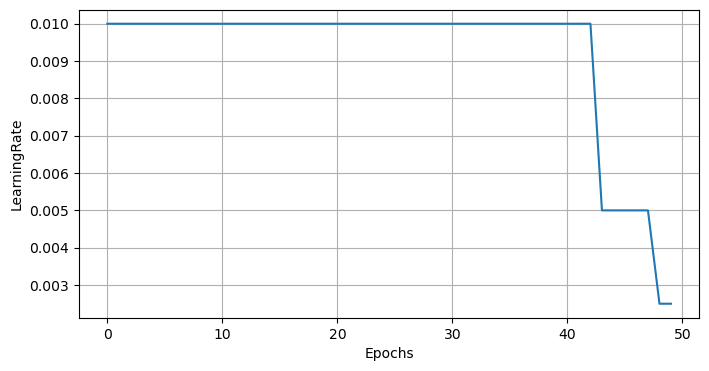

In [48]:
 plt.figure(figsize=(8,4))

plt.plot(history4.history['lr'])
plt.ylabel('LearningRate')
plt.xlabel('Epochs')
plt.grid(True);